# Memory-Augmented Autoencoder

## Import modules

In [1]:
import os 
import glob as glob

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Load data

In [2]:
X_train = pd.read_csv("F_mnist/train.csv")
X_test = pd.read_csv("F_mnist/test.csv")

In [3]:
X_train = X_train.iloc[:,2:].values
X_valid = X_test.iloc[:,1:].values
X_train, X_valid = X_train/255, X_valid/255

X_train = X_train.reshape(X_train.shape[0],28,28)
X_valid = X_valid.reshape(X_valid.shape[0],28,28)

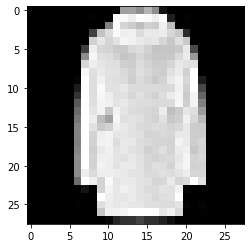

In [4]:
plt.imshow(X_train[6,:,:], cmap="gray")
plt.show()

## Declare model 

In [5]:
class MemoryBank(layers.Layer):
    def __init__(self, mem_dim, fea_dim):
        super(MemoryBank, self).__init__()
        self.mem_dim = mem_dim
        self.fea_dim = fea_dim

        memory_weight_init = tf.random_normal_initializer()
        self.memory_weight = tf.Variable(
            initial_value=memory_weight_init(shape=(self.mem_dim, self.fea_dim), dtype="float32"),
            trainable=True,
        )
        
    def cosine_sim(self, a, b):
        num = tf.linalg.matmul(a, tf.transpose(b, perm=[1, 0]))
        denom_a =  tf.math.sqrt(tf.math.reduce_sum(a**2,axis=1,keepdims=True))
        denom_b = tf.math.sqrt(tf.math.reduce_sum(b**2,axis=1,keepdims=True))
        denom =  tf.linalg.matmul(denom_a,tf.transpose(denom_b))
        w = (num + 1e-12) / (denom + 1e-12)
        return w   

    def sparse_shink(self,x,mem_dim):
        lamb = 1 / mem_dim # may need to be tuned!!!
        num = tf.keras.activations.relu(x - lamb)*x
        denom = tf.abs(x - lamb) + 1e-12
        wh = (num + 1e-12) / denom 
        wh_renorm = wh/tf.norm(wh,ord=1,axis=1,keepdims=True)
        return wh_renorm 
        
    def call(self, z):
        d = self.cosine_sim(z,self.memory_weight)
        w = tf.nn.softmax(d)
        wh_renorm = self.sparse_shink(w,self.mem_dim)
        z_hat = tf.linalg.matmul(wh_renorm,self.memory_weight)
        return z_hat, wh_renorm

In [6]:
class MemAE(keras.Model):
    def __init__(self, **kwargs):
        super(MemAE, self).__init__(**kwargs)
        self.encoder = self.getEncoder()
        self.decoder = self.getDecoder()
        
    def getEncoder(self):
        encoder_inputs = keras.Input(shape=(28, 28))
        x = keras.layers.Flatten()(encoder_inputs)
        x = layers.Dense(150,activation="selu")(x)
        x = layers.Dense(60,activation="selu")(x)
        z_hat, wh_renorm = MemoryBank(30,60)(x)
        encoder = keras.Model(encoder_inputs, [z_hat, wh_renorm], name="encoder")
        return encoder 
        
    def getDecoder(self):
        latent_inputs = keras.Input(shape=(60))
        x = layers.Dense(60,activation="selu")(latent_inputs)
        x = layers.Dense(240,activation="selu")(x)
        x = layers.Dense(784,activation="sigmoid")(x)
        decoder_outputs = keras.layers.Reshape([28, 28])(x)
        decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
        return decoder
        
    def train_step(self, x):
    
        with tf.GradientTape() as tape:
            z_hat, wh_renorm = self.encoder(x)
            x_hat = self.decoder(z_hat)

            mse = tf.reduce_sum(tf.square(x - x_hat))
            mem_etrp = tf.reduce_sum((-wh_renorm) * tf.math.log(wh_renorm + 1e-12))
            loss = tf.reduce_mean(mse + (0.0002 * mem_etrp))
            
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss}
    
    def test_step(self, data):
        x, y = data[0],data[1]
        z_hat, wh_renorm = self.encoder(x)
        x_hat = self.decoder(z_hat)

        mse = tf.reduce_sum(tf.square(x - x_hat))
        mem_etrp = tf.reduce_sum((-wh_renorm) * tf.math.log(wh_renorm + 1e-12))
        loss = tf.reduce_mean(mse + (0.0002 * mem_etrp))
        return {"loss": loss}
    
    def call(self, inputs):
        z_hat, w_hat = self.encoder(inputs)
        x_hat = self.decoder(z_hat)
        return x_hat, w_hat

## Train model 

In [7]:
model = MemAE()
#model.compile(optimizer=keras.optimizers.Adam(),run_eagerly=True)
model.compile(optimizer=keras.optimizers.Adam())
model.fit(X_train,validation_data=(X_valid,X_valid), epochs=50, batch_size=32)

Epoch 1/50
1875/1875 [==============================] - 6s 3ms/step - loss: 1251.0300 - val_loss: 477.0425
Epoch 2/50
1875/1875 [==============================] - 4s 2ms/step - loss: 775.8394 - val_loss: 347.5378
Epoch 3/50
1875/1875 [==============================] - 4s 2ms/step - loss: 663.7952 - val_loss: 342.5687
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 647.0506 - val_loss: 317.3023
Epoch 5/50
1875/1875 [==============================] - 3s 2ms/step - loss: 632.3334 - val_loss: 344.2504
Epoch 6/50
1875/1875 [==============================] - 3s 2ms/step - loss: 608.3414 - val_loss: 314.4004
Epoch 7/50
1875/1875 [==============================] - 3s 2ms/step - loss: 598.0290 - val_loss: 322.6079
Epoch 8/50
1875/1875 [==============================] - 3s 2ms/step - loss: 605.8072 - val_loss: 315.6419
Epoch 9/50
1875/1875 [==============================] - 3s 2ms/step - loss: 617.1091 - val_loss: 333.3849
Epoch 10/50
1875/1875 [======================

## Test model

### In sample

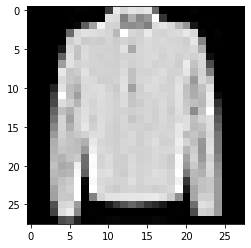

In [8]:
plt.imshow(X_train[8,:,:], cmap="gray")
plt.show()

(1, 28, 28)


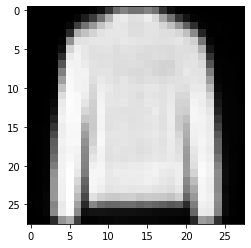

In [9]:
i = X_train[8,:,:].reshape(1,28,28)
print(i.shape)
xh, _ = model(i)
plt.imshow(xh[0,:,:], cmap="gray")
plt.show()

## Out of sample

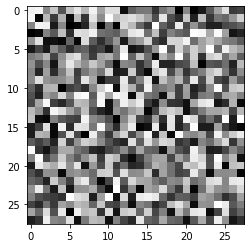

In [10]:
noise = np.random.rand(1,28,28)
plt.imshow(noise[0,:,:], cmap="gray")
plt.show()

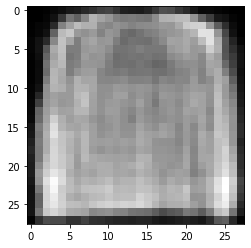

In [11]:
xh_noise, _ = model(noise)
plt.imshow(xh_noise[0,:,:], cmap="gray")
plt.show()